Pull data from API here

PS: 
- given Bitcoin on-chain data, what are the factors that most affect price movement?
- What categories can be identified in the Bitcoin addresses/wallets? (use clustering technique)


Dataset: APIs from Glassnode, Coinmetrics.io, Nansen.AI, Dune Analytics, Graph Protocol, Skew.

Analysis piece based on the Bitcoin cryptocurrency on-chain data to analyze important factors and their relationship with asset price. Especial focus on wallets and addresses to classify them into meaningful clusters (i.e. exchanges, miners, whales, institutional investors, retail investors etc) and "old-coin" movement (coins that were purchased a while ago and have not moved, another subset of early 'OG' investors in the space).
This could be replicated to other digital assets, such as Ethereum and its universe of tokens, depending on structure of data pull from APIs cited above.



Lots of EDA and subsequent predictive modeling with regression models + classification modeling for clustering.

A linear regression, a decision tree ensemble, and a neural net should cover your bases in terms of prediction models (LIightGBM is probably the best decision tree ensemble). Your PS is all about factors, so you'll want to pay attention to feature importances.



## Imports
---

In [1]:
# Standards
import pandas as pd
import numpy as np

# API
import requests
import requests as req
import json
import iso8601

# Automating
import glob
import time
from time import sleep
import datetime as dt
import warnings
import sys

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (16, 9)


from IPython import get_ipython
ipython = get_ipython()

if 'ipython' in globals():
    ipython.magic('matplotlib inline')

# Supress warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
# pip install coinmetrics-api-client

## API Scraping
---

## Glassnode API

### Custom Class to Get Data

Created a custom class that pulls Glassnode data via its API.

In [3]:
# https://github.com/glassnode/glassnode-api-python-client

class GlassnodeClient:

  def __init__(self):
    self._api_key = ''

  @property
  def api_key(self):
    return self._api_key

  def set_api_key(self, value):
    self._api_key = value

  def get(self, url, a='BTC', i='24h', c='native', e=None, s=None, u=None):
    p = dict()
    p['a'] = a
    p['i'] = i
    p['c'] = c

    if s is not None:
      try:
        p['s'] = iso8601.parse_date(s).strftime('%s')
      except ParseError:
        p['s'] = s

    if u is not None:
      try:
        p['u'] = iso8601.parse_date(u).strftime('%s')
      except ParseError:
        p['u'] = s

    p['api_key'] = self.api_key

    r = requests.get(url, params=p)

    try:
       r.raise_for_status()
    except Exception as e:
        print(e)
        print(r.text)

    try:
        df = pd.DataFrame(json.loads(r.text))
        df = df.set_index('t')
        df.index = pd.to_datetime(df.index, unit='s')
        df = df.sort_index()
        col_name = '_'.join(url.split('/')[-2:])
        df.rename(columns = {'v': col_name}, inplace = True)
#         s = df.v
#         s.name = '_'.join(url.split('/')[-2:])
        return df
    except Exception as e:
        print(e)
        
"""
List of possible parameters for API:
a
REQUIRED
string
asset symbol (only: BTC, LTC, BCH)

e
OPTIONAL
string
exchange (see /endpoints)

s
OPTIONAL
integer
since, unix timestamp

u
OPTIONAL
integer
until, unix timestamp

i
OPTIONAL
string
frequency interval, 1h, 10m or 24h (default)

f
OPTIONAL
string
format, csv or json (default)

c
OPTIONAL
string
currency, usd or native (default)
"""

'\nList of possible parameters for API:\na\nREQUIRED\nstring\nasset symbol (only: BTC, LTC, BCH)\n\ne\nOPTIONAL\nstring\nexchange (see /endpoints)\n\ns\nOPTIONAL\ninteger\nsince, unix timestamp\n\nu\nOPTIONAL\ninteger\nuntil, unix timestamp\n\ni\nOPTIONAL\nstring\nfrequency interval, 1h, 10m or 24h (default)\n\nf\nOPTIONAL\nstring\nformat, csv or json (default)\n\nc\nOPTIONAL\nstring\ncurrency, usd or native (default)\n'

In [4]:
gn = GlassnodeClient()

In [5]:
gn.set_api_key('2eea6100-6a2f-44cc-a965-455b897fe07b')

In [6]:
today = dt.datetime.today().strftime("%Y-%m-%d")
today

'2020-11-13'

In [7]:
# ADDRESSES

In [8]:
total_addresses = gn.get('https://api.glassnode.com/v1/metrics/addresses/count',  a='btc', s='2010', u=today)
total_addresses.to_csv('data/total_addresses.csv')
print(total_addresses.shape)
total_addresses.tail(2)

(3969, 1)


,addresses_count
t,
2020-11-11,734130462
2020-11-12,734649966


In [9]:
active_addresses = gn.get('https://api.glassnode.com/v1/metrics/addresses/active_count',  a='btc', s='2010', u=today)
active_addresses.to_csv('data/active_addresses.csv')
print(active_addresses.shape)
active_addresses.head(2)

(3969, 1)


,addresses_active_count
t,
2010-01-01,4
2010-01-02,0


In [10]:
new_addresses = gn.get('https://api.glassnode.com/v1/metrics/addresses/new_non_zero_count',  a='btc', s='2010', u=today)
new_addresses.to_csv('data/new_addresses.csv')
print(new_addresses.shape)
new_addresses.head(2)

(3969, 1)


,addresses_new_non_zero_count
t,
2010-01-01,134
2010-01-02,126


In [11]:
min_10k_addresses = gn.get('https://api.glassnode.com/v1/metrics/addresses/min_10k_count',  a='btc', s='2010', u=today)
min_10k_addresses.to_csv('data/min_10k_addresses.csv')
print(min_10k_addresses.shape)
min_10k_addresses.tail(2)

(3969, 1)


,addresses_min_10k_count
t,
2020-11-11,111
2020-11-12,111


In [12]:
min_1k_addresses = gn.get('https://api.glassnode.com/v1/metrics/addresses/min_1k_count',  a='btc', s='2010', u=today)
min_1k_addresses.to_csv('data/min_1k_addresses.csv')
print(min_1k_addresses.shape)
min_1k_addresses.tail(2)

(3969, 1)


,addresses_min_1k_count
t,
2020-11-11,2231
2020-11-12,2230


In [13]:
non_zero_addresses = gn.get('https://api.glassnode.com/v1/metrics/addresses/non_zero_count',  a='btc', s='2010', u=today)
non_zero_addresses.to_csv('data/non_zero_addresses.csv')
print(non_zero_addresses.shape)
non_zero_addresses.tail(2)

(3969, 1)


,addresses_non_zero_count
t,
2020-11-11,32453384
2020-11-12,32460139


In [14]:
addresses_profit = gn.get('https://api.glassnode.com/v1/metrics/addresses/profit_relative',  a='btc', s='2010', u=today)
addresses_profit.to_csv('data/addresses_profit.csv')
print(addresses_profit.shape)
addresses_profit.tail(2)

(3405, 1)


,addresses_profit_relative
t,
2019-11-11,0.714647
2019-11-12,0.725986


In [15]:
addresses_dist = gn.get('https://api.glassnode.com/v1/metrics/addresses/supply_distribution_relative',  a='btc', s='2010', u=today)
addresses_dist.to_csv('data/addresses_dist.csv')
print(addresses_dist.shape)
addresses_dist.tail(2)

(3603, 1)


,o
t,
2019-11-11,"{'0001_001': 0.001486693159923475, '001_01': 0..."
2019-11-12,"{'0001_001': 0.001490609658762449, '001_01': 0..."


In [16]:
accum_addresses = gn.get('https://api.glassnode.com/v1/metrics/addresses/accumulation_count',  a='btc', s='2010', u=today)
accum_addresses.to_csv('data/accum_addresses.csv')
print(accum_addresses.shape)
accum_addresses.tail(2)

(3603, 1)


,addresses_accumulation_count
t,
2019-11-11,458032
2019-11-12,458095


In [17]:
accum_balance = gn.get('https://api.glassnode.com/v1/metrics/addresses/accumulation_balance',  a='btc', s='2010', u=today)
accum_balance.to_csv('data/accum_balance.csv')
print(accum_balance.shape)
accum_balance.head(2)

(3603, 1)


,addresses_accumulation_balance
t,
2010-01-01,70018.15
2010-01-02,70018.15


In [18]:
# TRANSACTIONS

In [19]:
trans_count = gn.get('https://api.glassnode.com/v1/metrics/transactions/count',  a='btc', s='2010', u=today)
trans_count.to_csv('data/trans_count.csv')
print(trans_count.shape)
trans_count.tail(2)

(3969, 1)


,transactions_count
t,
2020-11-11,322130
2020-11-12,324695


In [20]:
trans_rate = gn.get('https://api.glassnode.com/v1/metrics/transactions/rate',  a='btc', s='2010', u=today)
trans_rate.to_csv('data/trans_rate.csv')
print(trans_rate.shape)
trans_rate.tail(2)

(3969, 1)


,transactions_rate
t,
2020-11-11,3.728356
2020-11-12,3.758044


In [21]:
# transf_count = gn.get('https://api.glassnode.com/v1/metrics/transactions/transfers_count',  a='eth', s='2015', u='2019')
# transf_count.to_csv('data/transf_count.csv')
# print(transf_count.shape)
# transf_count.tail(2)

In [22]:
trans_size = gn.get('https://api.glassnode.com/v1/metrics/transactions/size_sum',  a='btc', s='2010', u=today)
trans_size.to_csv('data/trans_size.csv')
print(trans_size.shape)
trans_size.tail(2)

(3969, 1)


,transactions_size_sum
t,
2020-11-11,190626630.0
2020-11-12,199554177.0


In [23]:
transf_adj_vol = gn.get('https://api.glassnode.com/v1/metrics/transactions/transfers_volume_adjusted_sum',  a='btc', s='2010', u=today)
transf_adj_vol.to_csv('data/transf_adj_vol.csv')
print(transf_adj_vol.shape)
transf_adj_vol.tail(2)

(3969, 1)


,transactions_transfers_volume_adjusted_sum
t,
2020-11-11,573006.909133
2020-11-12,621611.969407


In [24]:
ent_adj_count = gn.get('https://api.glassnode.com/v1/metrics/transactions/entity_adjusted_count',  a='btc', s='2010', u=today)
ent_adj_count.to_csv('data/ent_adj_count.csv')
print(ent_adj_count.shape)
ent_adj_count.tail(2)

(3603, 1)


,transactions_entity_adjusted_count
t,
2019-11-11,226240
2019-11-12,220610


In [25]:
ent_adj_vol = gn.get('https://api.glassnode.com/v1/metrics/transactions/transfers_volume_entity_adjusted_sum',  a='btc', s='2010', u=today)
ent_adj_vol.to_csv('data/ent_adj_vol.csv')
print(ent_adj_vol.shape)
ent_adj_vol.tail(2)

(3603, 1)


,transactions_transfers_volume_entity_adjusted_sum
t,
2019-11-11,175936.771925
2019-11-12,216643.710252


In [26]:
miner_netflow = gn.get('https://api.glassnode.com/v1/metrics/transactions/transfers_volume_miners_net',  a='btc', s='2010', u=today)
miner_netflow.to_csv('data/miner_netflow.csv')
print(miner_netflow.shape)
miner_netflow.tail(2)

(3603, 1)


,transactions_transfers_volume_miners_net
t,
2019-11-11,228.466552
2019-11-12,-317.148431


In [27]:
# ENTITIES

In [28]:
new_entities = gn.get('https://api.glassnode.com/v1/metrics/entities/new_count',  a='btc', s='2010', u=today)
new_entities.to_csv('data/new_entities.csv')
print(new_entities.shape)
new_entities.tail(2)

(3603, 1)


,entities_new_count
t,
2019-11-11,98125
2019-11-12,97390


In [29]:
entities_growth = gn.get('https://api.glassnode.com/v1/metrics/entities/net_growth_count',  a='btc', s='2010', u=today)
entities_growth.to_csv('data/entities_growth.csv')
print(entities_growth.shape)
entities_growth.tail(2)

(3603, 1)


,entities_net_growth_count
t,
2019-11-11,9131
2019-11-12,10875


In [30]:
whales = gn.get('https://api.glassnode.com/v1/metrics/entities/min_1k_count',  a='btc', s='2010', u=today)
whales.to_csv('data/whales.csv')
print(whales.shape)
whales.tail(2)

(3603, 1)


,entities_min_1k_count
t,
2019-11-11,1734
2019-11-12,1733


In [31]:
active_entities = gn.get('https://api.glassnode.com/v1/metrics/entities/active_count',  a='btc', s='2010', u=today)
active_entities.to_csv('data/active_entities.csv')
print(active_entities.shape)
active_entities.tail(2)

(3603, 1)


,entities_active_count
t,
2019-11-11,226290
2019-11-12,222895


In [32]:
receiving_entities = gn.get('https://api.glassnode.com/v1/metrics/entities/receiving_count',  a='btc', s='2010', u=today)
receiving_entities.to_csv('data/receiving_entities.csv')
print(receiving_entities.shape)
receiving_entities.tail(2)

(3603, 1)


,entities_receiving_count
t,
2019-11-11,173562
2019-11-12,172149


In [33]:
profit_entities = gn.get('https://api.glassnode.com/v1/metrics/entities/profit_relative',  a='btc', s='2010', u=today)
profit_entities.to_csv('data/profit_entities.csv')
print(profit_entities.shape)
profit_entities.tail(2)

(3405, 1)


,entities_profit_relative
t,
2019-11-11,0.749356
2019-11-12,0.756541


In [34]:
entities_dist = gn.get('https://api.glassnode.com/v1/metrics/entities/supply_distribution_relative',  a='btc', s='2010', u=today)
entities_dist.to_csv('data/entities_dist.csv')
print(entities_dist.shape)
entities_dist.tail(2)

(3603, 1)


,o
t,
2019-11-11,"{'0001_001': 0.00115673230985817, '001_01': 0...."
2019-11-12,"{'0001_001': 0.00115785889037855, '001_01': 0...."


In [35]:
# MARKET

In [36]:
closing_price = gn.get('https://api.glassnode.com/v1/metrics/market/price_usd_close',  a='btc', s='2010', u=today)
closing_price.to_csv('data/closing_price.csv')
print(closing_price.shape)
closing_price.tail(2)

(3772, 1)


,market_price_usd_close
t,
2020-11-11,15693.906873
2020-11-12,16281.414512


In [170]:
ohlc_price = gn.get('https://api.glassnode.com/v1/metrics/market/price_usd_ohlc',  a='btc', s='2010', u=today)
ohlc_price_df = pd.DataFrame()
for i in range(len(ohlc_price['o'])):
    df = pd.DataFrame(ohlc_price.iloc[i]['o'].values()).T
    df.columns = ohlc_price.iloc[i]['o'].keys()
    ohlc_price_df =pd.concat([ohlc_price_df, df])
ohlc_price_df.index = ohlc_price.index
ohlc_price = ohlc_price_df
print(ohlc_price.shape)
ohlc_price.to_csv('data/ohlc_price.csv')
ohlc_price.tail(2)

(3772, 4)


,c,h,l,o
t,,,,
2020-11-11,15693.906873,15908.693496,15290.006817,15305.071062
2020-11-12,16281.414512,16304.983801,15534.843122,15687.777568


In [38]:
pct_from_ath = gn.get('https://api.glassnode.com/v1/metrics/market/price_drawdown_relative',  a='btc', s='2010', u=today)
pct_from_ath.to_csv('data/pct_from_ath.csv')
print(pct_from_ath.shape)
pct_from_ath.tail(2)

(3772, 1)


,market_price_drawdown_relative
t,
2020-11-11,-0.207856
2020-11-12,-0.178202


In [39]:
realized_price = gn.get('https://api.glassnode.com/v1/metrics/market/price_realized_usd',  a='btc', s='2010', u=today)
realized_price.to_csv('data/realized_price.csv')
print(realized_price.shape)
realized_price.tail(2)

(3969, 1)


,market_price_realized_usd
t,
2020-11-11,6840.065375
2020-11-12,6863.084818


In [40]:
market_cap = gn.get('https://api.glassnode.com/v1/metrics/market/marketcap_usd',  a='btc', s='2010', u=today)
market_cap.to_csv('data/market_cap.csv')
print(market_cap.shape)
market_cap.tail(2)

(3772, 1)


,market_marketcap_usd
t,
2020-11-11,2.887422e+11
2020-11-12,2.948325e+11


In [41]:
realized_mcap = gn.get('https://api.glassnode.com/v1/metrics/market/marketcap_realized_usd',  a='btc', s='2010', u=today)
realized_mcap.to_csv('data/realized_mcap.csv')
print(realized_mcap.shape)
realized_mcap.tail(2)

(3969, 1)


,market_marketcap_realized_usd
t,
2020-11-11,1.268197e+11
2020-11-12,1.272534e+11


In [42]:
mvrv = gn.get('https://api.glassnode.com/v1/metrics/market/mvrv',  a='btc', s='2010', u=today)
mvrv.to_csv('data/mvrv.csv')
print(mvrv.shape)
mvrv.tail(2)

(3772, 1)


,market_mvrv
t,
2020-11-11,2.276793
2020-11-12,2.316893


In [43]:
mvrv_z = gn.get('https://api.glassnode.com/v1/metrics/market/mvrv_z_score',  a='btc', s='2010', u=today)
mvrv_z.to_csv('data/mvrv_z.csv')
print(mvrv_z.shape)
mvrv_z.tail(2)

(3771, 1)


,market_mvrv_z_score
t,
2020-11-11,2.411581
2020-11-12,2.491910


In [44]:
lt_mvrv = gn.get('https://api.glassnode.com/v1/metrics/market/mvrv_more_155',  a='btc', s='2010', u=today)
lt_mvrv.to_csv('data/lt_mvrv.csv')
print(lt_mvrv.shape)
lt_mvrv.tail(2)

(3251, 1)


,market_mvrv_more_155
t,
2019-11-11,1.847862
2019-11-12,1.860393


In [45]:
st_mvrv = gn.get('https://api.glassnode.com/v1/metrics/market/mvrv_less_155',  a='btc', s='2010', u=today)
st_mvrv.to_csv('data/st_mvrv.csv')
print(st_mvrv.shape)
st_mvrv.tail(2)

(3406, 1)


,market_mvrv_less_155
t,
2019-11-11,0.903754
2019-11-12,0.910524


In [46]:
# FUTURES

In [47]:
# EXCHANGES

In [48]:
# SUPPLY

In [49]:
# UTXO

In [50]:
# FEES

In [51]:
# MINING

In [52]:
# DISTRIBUTION

In [53]:
# INDICATORS

In [54]:
sopr = gn.get('https://api.glassnode.com/v1/metrics/indicators/sopr', a = 'btc', s='2010', u='2020-11-03')
sopr.to_csv('data/sopr.csv')
print(sopr.shape)
sopr.tail(2)

(3762, 1)


,indicators_sopr
t,
2020-11-01,1.008232
2020-11-02,1.009327


In [55]:
sopr.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3762 entries, 2010-07-17 to 2020-11-02
Data columns (total 1 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   indicators_sopr  3762 non-null   float64
dtypes: float64(1)
memory usage: 58.8 KB


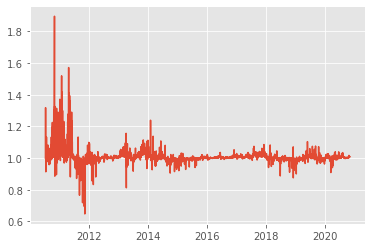

In [56]:
plt.plot(sopr);

In [57]:
adj_sopr = gn.get('https://api.glassnode.com/v1/metrics/indicators/sopr_adjusted', a = 'btc', s='2010', u='2020-11-03')
adj_sopr.to_csv('data/adj_sopr.csv')
print(adj_sopr.shape)
adj_sopr.tail(2)

(3762, 1)


,indicators_sopr_adjusted
t,
2020-11-01,1.043032
2020-11-02,1.047721


In [58]:
lth_sopr = gn.get('https://api.glassnode.com/v1/metrics/indicators/sopr_more_155', a = 'btc', s='2010', u='2020-11-03')
lth_sopr.to_csv('data/lth_sopr.csv')
print(lth_sopr.shape)
lth_sopr.tail(2)

(3247, 1)


,indicators_sopr_more_155
t,
2019-11-11,1.686662
2019-11-12,1.099436


In [59]:
sth_sopr = gn.get('https://api.glassnode.com/v1/metrics/indicators/sopr_less_155', a = 'btc', s='2010', u='2020-11-03')
sth_sopr.to_csv('data/sth_sopr.csv')
print(sth_sopr.shape)
sth_sopr.tail(2)

(3405, 1)


,indicators_sopr_less_155
t,
2019-11-11,0.988730
2019-11-12,0.989607


In [60]:
ntv = gn.get('https://api.glassnode.com/v1/metrics/indicators/nvt', a = 'btc', s='2010', u='2020-11-03')
ntv.to_csv('data/ntv.csv')
print(ntv.shape)
ntv.tail(2)

(3761, 1)


,indicators_nvt
t,
2020-11-01,47.832208
2020-11-02,29.419122


In [61]:
ntvs = gn.get('https://api.glassnode.com/v1/metrics/indicators/nvts', a = 'btc', s='2010', u='2020-11-03')
ntvs.to_csv('data/ntvs.csv')
print(ntvs.shape)
ntvs.tail(2)

(3761, 1)


,indicators_nvts
t,
2020-11-01,40.719971
2020-11-02,40.044418


In [62]:
reserve_risk = gn.get('https://api.glassnode.com/v1/metrics/indicators/reserve_risk', a = 'btc', s='2010', u='2020-11-03')
reserve_risk.to_csv('data/reserve_risk.csv')
print(reserve_risk.shape)
reserve_risk.tail(2)

(3733, 1)


,indicators_reserve_risk
t,
2020-11-01,0.002290
2020-11-02,0.002258


In [63]:
liveliness = gn.get('https://api.glassnode.com/v1/metrics/indicators/liveliness', a = 'btc', s='2010', u='2020-11-03')
liveliness.to_csv('data/liveliness.csv')
print(liveliness.shape)
liveliness.tail(2)

(3959, 1)


,indicators_liveliness
t,
2020-11-01,0.597399
2020-11-02,0.597476


In [64]:
realized_profit = gn.get('https://api.glassnode.com/v1/metrics/indicators/realized_profit', a = 'btc', s='2010', u='2020-11-03')
realized_profit.to_csv('data/realized_profit.csv')
print(realized_profit.shape)
realized_profit.tail(2)

(3762, 1)


,indicators_realized_profit
t,
2020-11-01,2.633819e+08
2020-11-02,3.721412e+08


In [65]:
nupl = gn.get('https://api.glassnode.com/v1/metrics/indicators/net_unrealized_profit_loss', a = 'btc', s='2010', u='2020-11-03')
nupl.to_csv('data/nupl.csv')
print(nupl.shape)
nupl.tail(2)

(3761, 1)


,indicators_net_unrealized_profit_loss
t,
2020-11-01,0.521869
2020-11-02,0.515162


In [66]:
lt_nupl = gn.get('https://api.glassnode.com/v1/metrics/indicators/nupl_more_155', a = 'btc', s='2010', u='2020-11-03')
lt_nupl.to_csv('data/lt_nupl.csv')
print(lt_nupl.shape)
lt_nupl.tail(2)

(3607, 1)


,indicators_nupl_more_155
t,
2020-11-01,0.592573
2020-11-02,0.588429


In [67]:
puell = gn.get('https://api.glassnode.com/v1/metrics/indicators/puell_multiple', a = 'btc', s='2010', u='2020-11-03')
puell.to_csv('data/puell.csv')
print(puell.shape)
puell.tail(2)

(3398, 1)


,indicators_puell_multiple
t,
2020-11-01,0.883858
2020-11-02,0.664141


In [68]:
hodled_lost = gn.get('https://api.glassnode.com/v1/metrics/indicators/hodled_lost_coins', a = 'btc', s='2010', u='2020-11-03')
hodled_lost.to_csv('data/hodled_lost.csv')
print(hodled_lost.shape)
hodled_lost.tail(2)

(3603, 1)


,indicators_hodled_lost_coins
t,
2019-11-11,7.023522e+06
2019-11-12,7.026466e+06


In [69]:
s2f = gn.get('https://api.glassnode.com/v1/metrics/indicators/stock_to_flow_ratio', a = 'btc', s='2010', u='2020-11-03')
s2f.to_csv('data/s2f.csv')
print(s2f.shape)
s2f.tail(2)

(3958, 1)


,o
t,
2020-11-01,"{'daysTillHalving': 1274, 'ratio': 23782.09278..."
2020-11-02,"{'daysTillHalving': 1273, 'ratio': 23964.59587..."


In [70]:
# s2f.loc['2020-11-02']

In [71]:
# s2f['o'][-1]['ratio']

In [72]:
ent_adj_sopr = gn.get('https://api.glassnode.com/v1/metrics/indicators/sopr_account_based', a = 'btc', s='2010', u='2020-11-03')
ent_adj_sopr.to_csv('data/ent_adj_sopr.csv')
print(ent_adj_sopr.shape)
ent_adj_sopr.tail(2)

(3405, 1)


,indicators_sopr_account_based
t,
2019-11-11,1.001608
2019-11-12,0.990341


In [73]:
ent_adj_liv = gn.get('https://api.glassnode.com/v1/metrics/indicators/liveliness_account_based', a = 'btc', s='2010', u='2020-11-03')
ent_adj_liv.to_csv('data/ent_adj_liv.csv')
print(ent_adj_liv.shape)
ent_adj_liv.tail(2)

(3603, 1)


,indicators_liveliness_account_based
t,
2019-11-11,0.610319
2019-11-12,0.610220


In [74]:
ent_adj_mvrv = gn.get('https://api.glassnode.com/v1/metrics/indicators/mvrv_account_based', a = 'btc', s='2010', u='2020-11-03')
ent_adj_mvrv.to_csv('data/ent_adj_mvrv.csv')
print(ent_adj_mvrv.shape)
ent_adj_mvrv.tail(2)

(3405, 1)


,indicators_mvrv_account_based
t,
2019-11-11,1.503845
2019-11-12,1.494573


In [75]:
ent_adj_nupl = gn.get('https://api.glassnode.com/v1/metrics/indicators/net_unrealized_profit_loss_account_based', a = 'btc', s='2010', u='2020-11-03')
ent_adj_nupl.to_csv('data/ent_adj_nupl.csv')
print(ent_adj_nupl.shape)
ent_adj_nupl.tail(2)

(3405, 1)


,indicators_net_unrealized_profit_loss_account_based
t,
2019-11-11,0.328175
2019-11-12,0.333054


In [76]:
ent_adj_lth_nupl = gn.get('https://api.glassnode.com/v1/metrics/indicators/nupl_more_155_account_based', a = 'btc', s='2010', u='2020-11-03')
ent_adj_lth_nupl.to_csv('data/ent_adj_lth_nupl.csv')
print(ent_adj_lth_nupl.shape)
ent_adj_lth_nupl.tail(2)

(3405, 1)


,indicators_nupl_more_155_account_based
t,
2019-11-11,0.498427
2019-11-12,0.501686


In [77]:
diff_ribbon = gn.get('https://api.glassnode.com/v1/metrics/indicators/difficulty_ribbon', a = 'btc', s='2010', u='2020-11-03')
diff_ribbon.to_csv('data/diff_ribbon.csv')
print(diff_ribbon.shape)
diff_ribbon.tail(2)

(3959, 1)


,o
t,
2020-11-01,"{'ma128': 76540176425025570000000, 'ma14': 858..."
2020-11-02,"{'ma128': 76681527546396830000000, 'ma14': 858..."


In [78]:
hash_ribbon = gn.get('https://api.glassnode.com/v1/metrics/indicators/hash_ribbon', a = 'btc', s='2010', u='2020-11-03')
hash_ribbon.to_csv('data/hash_ribbon.csv')
print(hash_ribbon.shape)
hash_ribbon.tail(2)

(3959, 1)


,o
t,
2020-11-01,"{'crossed': 0, 'ma30': 132116135061810950000, ..."
2020-11-02,"{'crossed': 0, 'ma30': 130467200605520760000, ..."


In [79]:
# merging all files into one dataframe
directoryPath = 'data/'
glued_data = pd.DataFrame()
for file_name in glob.glob(directoryPath+'*.csv'):
    x = pd.read_csv(file_name, low_memory=False)
    glued_data = pd.concat([glued_data,x],axis=0)

In [80]:
combined = glued_data.groupby('t').mean()

In [81]:
combined.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3969 entries, 2010-01-01 to 2020-11-12
Data columns (total 49 columns):
 #   Column                                               Non-Null Count  Dtype  
---  ------                                               --------------  -----  
 0   market_mvrv_more_155                                 3251 non-null   float64
 1   addresses_accumulation_balance                       3603 non-null   float64
 2   addresses_new_non_zero_count                         3969 non-null   float64
 3   indicators_sopr_account_based                        3405 non-null   float64
 4   indicators_sopr_adjusted                             3604 non-null   float64
 5   transactions_rate                                    3969 non-null   float64
 6   market_mvrv                                          3772 non-null   float64
 7   addresses_accumulation_count                         3603 non-null   float64
 8   entities_receiving_count                             3603 

In [82]:
((combined.isnull().sum())/len(combined)*100).sort_values(ascending = False)

indicators_sopr_more_155                               18.190980
market_mvrv_more_155                                   18.090199
indicators_puell_multiple                              14.386495
indicators_nupl_more_155_account_based                 14.210128
indicators_sopr_account_based                          14.210128
indicators_net_unrealized_profit_loss_account_based    14.210128
indicators_mvrv_account_based                          14.210128
entities_profit_relative                               14.210128
indicators_sopr_less_155                               14.210128
addresses_profit_relative                              14.210128
market_mvrv_less_155                                   14.184933
entities_net_growth_count                               9.221466
entities_receiving_count                                9.221466
addresses_accumulation_balance                          9.221466
transactions_entity_adjusted_count                      9.221466
indicators_liveliness_acc

In [83]:
len(combined.columns)

49

In [84]:
combined.to_csv('data/combined.csv')

## Coinmetrics API

In [85]:
import coinmetrics

In [86]:
# https://github.com/checkmatey/checkonchain/blob/master/general/coinmetrics_api.py
# Import Coinmetrics API
# from checkonchain.general.__init__ import *
import coinmetrics

cm = coinmetrics.Community() # Initialize a reference object, in this case `cm` for the Community API

class Coinmetrics_api:
       
    def __init__(self,asset,begin_timestamp,end_timestamp):
        print('...Fetching Coinmetrics API for '+asset+'...')
        # List all available metrics for BTC.
        self.asset = asset
        self.begin_timestamp=begin_timestamp
        self.end_timestamp=end_timestamp
        self.topcapconst = 35

    def collect_data(self):
        available_data_types = cm.get_available_data_types_for_asset(self.asset)
        metric_list = str((','.join(available_data_types))) #setup complete metric list
        #print(metric_list)
        asset_data = cm.get_asset_data_for_time_range(self.asset, metric_list, self.begin_timestamp, self.end_timestamp)
        return asset_data
    
    def convert_to_pd(self):
        asset_data = Coinmetrics_api.collect_data(self)
        df = coinmetrics.cm_to_pandas(asset_data)
        #Extract Data as column for ease of application
        df.index.name = 'date'
        df.reset_index(inplace=True)
        df['date'] = pd.to_datetime(df['date'])
        #Calc - block height
        df['blk']=df['BlkCnt'].cumsum()
        #Realised Price (Only if present, excludes XMR and ZEC et al.)
        if 'CapRealUSD' in df:
            df['PriceRealUSD'] = df['CapRealUSD']/df['SplyCur']
        #Calc - approx btc block height (Noting BTC blocks were mined from 9/Jan/09)
        df['btc_blk_est'] = (df['date'] - pd.to_datetime(np.datetime64('2009-01-09'),utc=True))
        df['btc_blk_est'] = df['btc_blk_est']/np.timedelta64(1,'D') #convert from timedelta to Days (float)
        df['btc_blk_est'] = df['btc_blk_est']*(24*6) #Note - corrected for neg values in loop below
        #Calc - Daily Issuance
        for i in range(0,len(df.index)):
            #Correct btc_blk_est
            df.loc[i,'btc_blk_est'] = max(0,df.loc[i,'btc_blk_est'])
            if i == 0:
                df.loc[i,'DailyIssuedNtv'] = df.loc[i,'SplyCur']
            else:
                df.loc[i,'DailyIssuedNtv'] = df.loc[i,'SplyCur'] - df.loc[i-1,'SplyCur']
        # Calc - inflation Rate,  S2F, S2F Model, S2F Price
        df['DailyIssuedUSD'] = df['DailyIssuedNtv'] * df['PriceUSD']            
        df['inf_pct_ann'] = df['DailyIssuedNtv']*365/df['SplyCur']
        df['S2F'] = 1/df['inf_pct_ann']     
        df = df.set_index('date')
        df.index = pd.to_datetime(df.index, unit='D')
        df = df.sort_index()
        return df

"""#############################  
    Coinmetrics Community API
BTC = Coinmetrics_api('btc',"2009-01-03","2019-10-07").convert_to_pd()  
################################"""

"""Example Calculations"""
#BTC = Coinmetrics_api('btc',"2009-01-03","2019-10-07").convert_to_pd()
#LTC = Coinmetrics_api('ltc',"2011-10-07",today).convert_to_pd()
#BCH = Coinmetrics_api('bch',"2017-08-01",today).convert_to_pd()
#DASH = Coinmetrics_api('dash',"2014-01-19",today).convert_to_pd()
#DCR = Coinmetrics_api('dcr',"2016-02-08",today).convert_to_pd()
#XMR = Coinmetrics_api('xmr',"2014-04-18",today).convert_to_pd()
#ZEC = Coinmetrics_api('zec',"2016-10-28",today).convert_to_pd()
#ETH = Coinmetrics_api('eth',"2015-07-30",today).convert_to_pd()

"""Time Metrics"""
# date               -datetime64[ns, UTC]
# blk                -ADDED METRIC - block height (Sum of BlkCnt)
# btc_blk_est        -ADDED METRIC - Estimated Bitcoin block-height (Assumes 10min block-times)

"""Blockchain Metrics"""
# AdrActCnt          -Active Addresses
# BlkCnt             -Block Count (Daily)
# BlkSizeByte        -Block Size (Bytes)
# BlkSizeMeanByte    -Block Size Average (Bytes)
# SplyCur            -Current Coin Supply
# inf_pct_ann        -ADDED METRIC - Inflation % annual
# S2F                -ADDED METRIC - Stock-to-Flow Ratio

"""Network Valuation Models"""
# CapMrktCurUSD      - Market Cap
# CapRealUSD         - Realised Cap

"""Network Pricing Models"""
# PriceUSD           - Coin Price USD
# PriceRealised      - Realised Price USD

"""Network Valuation Oscillators"""
# CapMVRVCur         - MVRV Ratio - Market Cap / Realised Cap
# NVTAdj             - NVT Ratio (Adjusted Volume)
# NVTAdj90           - NVT Ratio 90D MA (Adjusted Volume)

"""Transaction Flow Metrics"""
# TxCnt              -Count of Transactions
# TxTfrCnt           -Count of Transaction Transfers (Cleaned Data)
# TxTfrValAdjNtv     -Native Units Transferred (Adjusted Data)
# TxTfrValAdjUSD     -USD Value Transferred (Adjusted Data)
# TxTfrValNtv        -Total Native Units Value Transferred
# TxTfrValUSD        -Total USD Value Transferred
# TxTfrValMeanNtv    -Mean Native Units Transferred
# TxTfrValMeanUSD    -Mean USD Value Transferred
# TxTfrValMedNtv     -Median Native Units Transferred
# TxTfrValMedUSD     -Median USD Value Transferred

"""Miner Metrics"""
# DiffMean          - Average Difficulty
# FeeMeanNtv        - Mean Fee paid in Native Coins (Daily)
# FeeMeanUSD        - Mean Fee paid in USD (Daily)
# FeeMedNtv         - Median Fee paid in Native Coins (Daily)
# FeeMedUSD         - Mean Fee paid in USD (Daily)
# FeeTotNtv         - Total Fees paid in Native Coins (Daily)
# FeeTotUSD         - Total Fees paid in Native Coins (Daily)
# IssContNtv        - Daily Issued Native Coins to Miners/Validators
# IssContPctAnn     - Annualised Inflation Rate
# IssContUSD        - Daily Issued USD to Miners/Validators
# IssTotNtvDaily    - Issued Native Coins to Miners/Validators (Daily)
# IssTotUSD         - Daily Issued USD Value to Miners/Validators (Daily)
# DailyIssuedNtv    - ADDED METRIC - Daily Issued Native Units (Sply_n - Sply_n-1)
# DailyIssuedUSD    - ADDED METRIC - Daily Issued USD Value (Sply_n - Sply_n-1)

"""Market Specific Metrics"""
# ROI1yr
# ROI30d
# VtyDayRet180d
# VtyDayRet30d
# VtyDayRet60d

'Market Specific Metrics'

In [87]:
btc = Coinmetrics_api('btc',"2009-01-03","2020-11-11").convert_to_pd()

...Fetching Coinmetrics API for btc...


In [88]:
btc

,AdrActCnt,BlkCnt,BlkSizeByte,BlkSizeMeanByte,CapMVRVCur,CapMrktCurUSD,CapRealUSD,DiffMean,FeeMeanNtv,FeeMeanUSD,...,VtyDayRet180d,VtyDayRet30d,VtyDayRet60d,blk,PriceRealUSD,btc_blk_est,DailyIssuedNtv,DailyIssuedUSD,inf_pct_ann,S2F
date,,,,,,,,,,,,,,,,,,,,,
2009-01-03 00:00:00+00:00,0.0,0.0,0.0,NaN,NaN,NaN,0.000000e+00,NaN,NaN,NaN,...,NaN,NaN,NaN,0.0,NaN,0.0,0.00,NaN,NaN,NaN
2009-01-04 00:00:00+00:00,0.0,0.0,0.0,NaN,NaN,NaN,0.000000e+00,NaN,NaN,NaN,...,NaN,NaN,NaN,0.0,NaN,0.0,0.00,NaN,NaN,NaN
2009-01-05 00:00:00+00:00,0.0,0.0,0.0,NaN,NaN,NaN,0.000000e+00,NaN,NaN,NaN,...,NaN,NaN,NaN,0.0,NaN,0.0,0.00,NaN,NaN,NaN
2009-01-06 00:00:00+00:00,0.0,0.0,0.0,NaN,NaN,NaN,0.000000e+00,NaN,NaN,NaN,...,NaN,NaN,NaN,0.0,NaN,0.0,0.00,NaN,NaN,NaN
2009-01-07 00:00:00+00:00,0.0,0.0,0.0,NaN,NaN,NaN,0.000000e+00,NaN,NaN,NaN,...,NaN,NaN,NaN,0.0,NaN,0.0,0.00,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-11-07 00:00:00+00:00,1055012.0,146.0,198604086.0,1.360302e+06,2.187115,2.755732e+11,1.259985e+11,1.678778e+13,0.000500,7.437259,...,0.026023,0.027211,0.022916,655902.0,6797.245754,622080.0,912.50,1.356555e+07,0.017968,55.655328
2020-11-08 00:00:00+00:00,920529.0,138.0,189145770.0,1.370622e+06,2.269764,2.873323e+11,1.265912e+11,1.678778e+13,0.000384,5.955396,...,0.026128,0.027797,0.023359,656040.0,6828.902721,622224.0,862.50,1.336875e+07,0.016982,58.884464
2020-11-09 00:00:00+00:00,1188873.0,185.0,252934375.0,1.367213e+06,2.237517,2.840099e+11,1.269308e+11,1.678778e+13,0.000440,6.745236,...,0.025851,0.028047,0.023476,656225.0,6846.795593,622368.0,1156.25,1.771354e+07,0.022765,43.927367


In [89]:
btc.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4331 entries, 2009-01-03 00:00:00+00:00 to 2020-11-11 00:00:00+00:00
Data columns (total 49 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   AdrActCnt           4331 non-null   float64
 1   BlkCnt              4331 non-null   float64
 2   BlkSizeByte         4331 non-null   float64
 3   BlkSizeMeanByte     4325 non-null   float64
 4   CapMVRVCur          3770 non-null   float64
 5   CapMrktCurUSD       3770 non-null   float64
 6   CapRealUSD          4331 non-null   float64
 7   DiffMean            4325 non-null   float64
 8   FeeMeanNtv          4073 non-null   float64
 9   FeeMeanUSD          3770 non-null   float64
 10  FeeMedNtv           4073 non-null   float64
 11  FeeMedUSD           3770 non-null   float64
 12  FeeTotNtv           4331 non-null   float64
 13  FeeTotUSD           3770 non-null   float64
 14  HashRate            4325 non-null   float64
 15  IssCont

In [90]:
btc.describe().T

,count,mean,std,min,25%,50%,75%,max
AdrActCnt,4331.0,3.385188e+05,3.313102e+05,0.000000e+00,1.657250e+04,2.226280e+05,6.376275e+05,1.290363e+06
BlkCnt,4331.0,1.515860e+02,3.539967e+01,0.000000e+00,1.380000e+02,1.520000e+02,1.660000e+02,6.920000e+02
BlkSizeByte,4331.0,7.151933e+07,6.590006e+07,0.000000e+00,3.243560e+06,4.909272e+07,1.346478e+08,2.565337e+08
BlkSizeMeanByte,4325.0,4.794857e+05,4.465189e+05,2.150000e+02,2.186920e+04,3.326637e+05,9.241188e+05,1.427240e+06
CapMVRVCur,3770.0,2.031872e+00,3.023176e+00,3.868285e-01,1.240460e+00,1.667594e+00,2.213414e+00,1.460383e+02
CapMrktCurUSD,3770.0,4.857693e+10,7.017752e+10,1.776705e+05,2.906799e+08,6.791451e+09,9.712132e+10,3.288988e+11
CapRealUSD,4331.0,2.597384e+10,3.997987e+10,0.000000e+00,4.298830e+07,4.163219e+09,4.541698e+10,1.276084e+11
DiffMean,4325.0,2.463861e+12,4.848286e+12,1.000000e+00,1.508590e+06,4.000747e+10,1.452840e+12,1.999734e+13
FeeMeanNtv,4073.0,9.251890e-04,7.781066e-03,0.000000e+00,1.381825e-04,2.317134e-04,6.831250e-04,2.200000e-01
FeeMeanUSD,3770.0,1.116054e+00,3.734099e+00,0.000000e+00,3.152316e-02,1.100606e-01,7.391014e-01,5.630812e+01


In [91]:
btc.corr()[['PriceUSD']].sort_values('PriceUSD', ascending = False)

,PriceUSD
PriceUSD,1.000000
CapMrktCurUSD,0.998868
IssTotUSD,0.938538
IssContUSD,0.938538
DailyIssuedUSD,0.938533
PriceRealUSD,0.932083
CapRealUSD,0.929990
TxTfrValAdjUSD,0.897306
TxTfrValMedUSD,0.867453
AdrActCnt,0.814975


In [92]:
abs(btc.corr()[['PriceUSD']]).sort_values('PriceUSD', ascending = False).head(20)

,PriceUSD
PriceUSD,1.000000
CapMrktCurUSD,0.998868
IssTotUSD,0.938538
IssContUSD,0.938538
DailyIssuedUSD,0.938533
PriceRealUSD,0.932083
CapRealUSD,0.929990
TxTfrValAdjUSD,0.897306
TxTfrValMedUSD,0.867453
AdrActCnt,0.814975


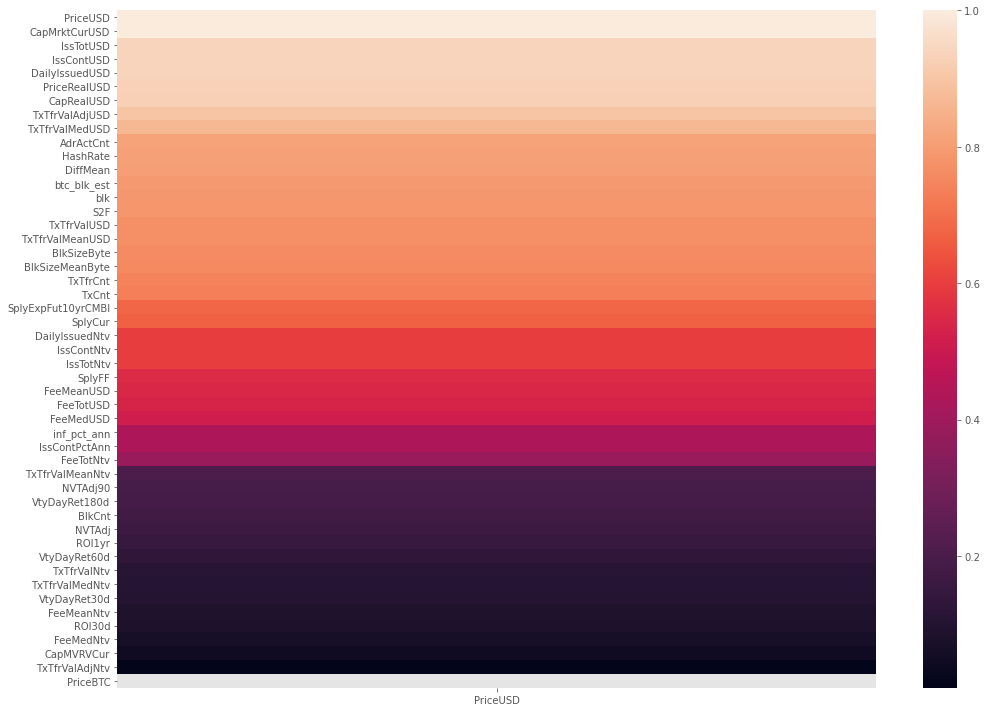

In [93]:
plt.figure(figsize = (15, 10))
sns.heatmap(abs(btc.corr()[['PriceUSD']]).sort_values('PriceUSD', ascending = False))
plt.tight_layout()

In [94]:
"""Time Metrics"""
# date               -datetime64[ns, UTC]
# blk                -ADDED METRIC - block height (Sum of BlkCnt)
# btc_blk_est        -ADDED METRIC - Estimated Bitcoin block-height (Assumes 10min block-times)
time_cols = ['date', 'blk', 'btc_blk_est']

In [95]:
"""Blockchain Metrics"""
# AdrActCnt          -Active Addresses
# BlkCnt             -Block Count (Daily)
# BlkSizeByte        -Block Size (Bytes)
# BlkSizeMeanByte    -Block Size Average (Bytes)
# SplyCur            -Current Coin Supply
# inf_pct_ann        -ADDED METRIC - Inflation % annual
# S2F                -ADDED METRIC - Stock-to-Flow Ratio
blockchain_cols = ['AdrActCnt', 'BlkCnt', 'BlkSizeByte', 'BlkSizeMeanByte', 'SplyCur', 'inf_pct_ann', 'S2F']

In [96]:
"""Network Valuation Models"""
# CapMrktCurUSD      - Market Cap
# CapRealUSD         - Realised Cap
market_val_cols = ['CapMrktCurUSD', 'CapRealUSD', 'Market Cap', 'Realised Cap']

In [97]:
"""Network Pricing Models"""
# PriceUSD           - Coin Price USD
# PriceRealised      - Realised Price USD
market_pricing_cols = ['PriceUSD', 'PriceRealised', 'Coin Price USD', 'Realised Price USD']

In [98]:
"""Network Valuation Oscillators"""
# CapMVRVCur         - MVRV Ratio - Market Cap / Realised Cap
# NVTAdj             - NVT Ratio (Adjusted Volume)
# NVTAdj90           - NVT Ratio 90D MA (Adjusted Volume)
market_oscil_cols = ['CapMVRVCur', 'NVTAdj', 'NVTAdj90', 'MVRV Ratio - Market Cap / Realised Cap', 
                      'NVT Ratio (Adjusted Volume)', 'NVT Ratio 90D MA (Adjusted Volume)']

In [99]:
"""Transaction Flow Metrics"""
# TxCnt              -Count of Transactions
# TxTfrCnt           -Count of Transaction Transfers (Cleaned Data)
# TxTfrValAdjNtv     -Native Units Transferred (Adjusted Data)
# TxTfrValAdjUSD     -USD Value Transferred (Adjusted Data)
# TxTfrValNtv        -Total Native Units Value Transferred
# TxTfrValUSD        -Total USD Value Transferred
# TxTfrValMeanNtv    -Mean Native Units Transferred
# TxTfrValMeanUSD    -Mean USD Value Transferred
# TxTfrValMedNtv     -Median Native Units Transferred
# TxTfrValMedUSD     -Median USD Value Transferred
transaction_cols = ['TxCnt', 'TxTfrCnt', 'TxTfrValAdjNtv', 'TxTfrValAdjUSD', 'TxTfrValNtv', 'TxTfrValUSD', 
                    'TxTfrValMeanNtv', 'TxTfrValMeanUSD' ,'TxTfrValMedNtv', 'TxTfrValMedUSD']

In [100]:
"""Miner Metrics"""
# DiffMean          - Average Difficulty
# FeeMeanNtv        - Mean Fee paid in Native Coins (Daily)
# FeeMeanUSD        - Mean Fee paid in USD (Daily)
# FeeMedNtv         - Median Fee paid in Native Coins (Daily)
# FeeMedUSD         - Mean Fee paid in USD (Daily)
# FeeTotNtv         - Total Fees paid in Native Coins (Daily)
# FeeTotUSD         - Total Fees paid in Native Coins (Daily)
# IssContNtv        - Daily Issued Native Coins to Miners/Validators
# IssContPctAnn     - Annualised Inflation Rate
# IssContUSD        - Daily Issued USD to Miners/Validators
# IssTotNtvDaily    - Issued Native Coins to Miners/Validators (Daily)
# IssTotUSD         - Daily Issued USD Value to Miners/Validators (Daily)
# DailyIssuedNtv    - ADDED METRIC - Daily Issued Native Units (Sply_n - Sply_n-1)
# DailyIssuedUSD    - ADDED METRIC - Daily Issued USD Value (Sply_n - Sply_n-1)
miner_cols = ['DiffMean', 'FeeMeanNtv', 'FeeMeanUSD', 'FeeMedNtv', 'FeeMedUSD', 'FeeTotNtv', 'FeeTotUSD',
              'IssContNtv', 'IssContPctAnn', 'IssContUSD', 'IssTotNtvDaily', 'IssTotUSD' ,'DailyIssuedNtv', 
              'DailyIssuedUSD']

In [101]:
"""Market Specific Metrics"""
# ROI1yr
# ROI30d
# VtyDayRet180d
# VtyDayRet30d
# VtyDayRet60d
market_metrics_cols = ['ROI1yr', 'ROI30d', 'VtyDayRet180d', 'VtyDayRet30d', 'VtyDayRet60d']

In [102]:
from chart_studio.plotly import plotly as py
from plotly import tools
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
import plotly.graph_objs as go
import gc